In [1]:
import re
import itertools
from collections import Counter
import pandas as pd
import string

import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download()
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
    
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
import re
import ast
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import scipy.sparse as sparse

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constant

In [3]:
itemID = 'asin'
userID = 'reviewerID'
rating = 'overall'
reviewText = 'reviewText'
summary = 'summary'
keyPhrase = 'keyVector'
binary = 'Binary'
helpful = 'helpful'
helpful_rating = 'helpful_rating'
total_helpful = 'total_helpful'
overall = 'overall'
dataPath = 'data/ToysGames/'
dataName = 'reviews_Toys_and_Games_5.json.gz'

## Load Data

In [4]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(dataPath+dataName)[[userID, itemID, helpful, reviewText, overall, summary]]
df[reviewText] = df[reviewText].astype('str')
df[summary] = df[summary].astype('str')
df[helpful] = df[helpful].astype('str')

In [5]:
df[df[reviewText].isnull()]

,reviewerID,asin,helpful,reviewText,overall,summary


In [6]:
# df_groupby_asin = df.groupby(itemID).agg({reviewText:','.join, summary:','.join})

In [7]:
# df_groupby_asin.head()

In [8]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    elif len(tags) == 3:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in acceptable_types and tags[3][1] in second_type:
            return True
        else:
            return False  

In [9]:
# Tokenize Review
df["review_word_tokenized"] = df[reviewText].apply(lambda x: nltk.word_tokenize(x)+[' '])

# Remove Stopwords
# Get english stopwords
en_stopwords = set(stopwords.words('english'))
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w for w in text if w not in en_stopwords])

# Remove Punctuation
table = str.maketrans('', '', string.punctuation)
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w.translate(table) for w in text])
    
# Remove tokens that are not alphabetic
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w for w in text if w.isalpha()])

# Lowercase
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [w.lower() for w in text])

# Lemmatizing
lemmatizer = WordNetLemmatizer()
df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
                                                                [lemmatizer.lemmatize(w) for w in text])

In [10]:
def process_dataset(df, use_lemmatizer=True, 
                    remove_user=True, num_user=10000, filter_user_criteria="num_reviews", 
                    remove_item=True, num_item=10000, filter_item_criteria="num_reviews", 
                    filter_by_type=True, freq_filter=100, num_keyPhrases=100):
    print("use_lemmatizer {}, num_user {}, filter_user_criteria {}, num_item {}, filter_item_criteria {}, filter_by_type {}, freq_filter {}".format(use_lemmatizer, num_user, filter_user_criteria, num_item, filter_item_criteria, filter_by_type, freq_filter))
    
#     # Tokenize Review
#     df["review_word_tokenized"] = df[reviewText].apply(lambda x: nltk.word_tokenize(x)+[' '])

#     # Remove Stopwords
#     # Get english stopwords
#     en_stopwords = set(stopwords.words('english'))
#     df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
#                                                                     [w for w in text if w not in en_stopwords])

#     # Remove Punctuation
#     table = str.maketrans('', '', string.punctuation)
#     df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
#                                                                     [w.translate(table) for w in text])
    
#     # Remove tokens that are not alphabetic
#     df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
#                                                                     [w for w in text if w.isalpha()])

#     # Lowercase
#     df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
#                                                                     [w.lower() for w in text])
    
#     if use_lemmatizer:
#         # Lemmatizing
#         lemmatizer = WordNetLemmatizer()
#         df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
#                                                                         [lemmatizer.lemmatize(w) for w in text])
#     else:
#         # Stemming
#         porter = PorterStemmer()
#         df["review_word_tokenized"] = df["review_word_tokenized"].apply(lambda text: 
#                                                                         [porter.stem(w) for w in text])
    
    if remove_user:
        df_user = df.groupby(userID, as_index=False).agg(lambda x: x.tolist())
        if filter_user_criteria == "num_reviews":
            df_user["num_reviews"] = df_user["review_word_tokenized"].str.len()
            df_user = df_user.sort_values("num_reviews", ascending=False)
            df_user.hist(column="num_reviews")
#             print("User DF head after filtered: \n {} \n".format(df_user.head(10)["num_reviews"]))
        elif filter_user_criteria == "num_words_in_reviews":
            df_user["review_word_tokenized"] = df_user["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_user["num_words_in_reviews"] = df_user["review_word_tokenized"].str.len()
            df_user = df_user.sort_values("num_words_in_reviews", ascending=False)
            df_user.hist(column="num_words_in_reviews")
#             print("User DF head after filtered: \n {} \n".format(df_user.head(10)["num_words_in_reviews"]))
        else:
            df_user["review_word_tokenized"] = df_user["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_user["review_word_tokenized"] = df_user["review_word_tokenized"].apply(lambda l: list(set(l)))
            df_user["num_unique_words_in_reviews"] = df_user["review_word_tokenized"].str.len()
            df_user = df_user.sort_values("num_unique_words_in_reviews", ascending=False)
            df_user.hist(column="num_unique_words_in_reviews")
#             print("User DF head after filtered: \n {} \n".format(df_user.head(10)["num_unique_words_in_reviews"]))

        filtered_userID = df_user.head(num_user)[userID].values
        df = df.loc[df[userID].isin(filtered_userID)]
    
    if remove_item:
        df_item = df.groupby(itemID, as_index=False).agg(lambda x: x.tolist())
        if filter_item_criteria == "num_reviews":
            df_item["num_reviews"] = df_item["review_word_tokenized"].str.len()
            df_item = df_item.sort_values("num_reviews", ascending=False)
            df_item.hist(column="num_reviews")
#             print("Item DF head after filtered: \n {} \n".format(df_item.head(10)["num_reviews"]))
        elif filter_item_criteria == "num_words_in_reviews":
            df_item["review_word_tokenized"] = df_item["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_item["num_words_in_reviews"] = df_item["review_word_tokenized"].str.len()
            df_item = df_item.sort_values("num_words_in_reviews", ascending=False)
            df_item.hist(column="num_words_in_reviews")
#             print("Item DF head after filtered: \n {} \n".format(df_item.head(10)["num_words_in_reviews"]))
        else:
            df_item["review_word_tokenized"] = df_item["review_word_tokenized"]. \
                                                    apply(lambda l: [item for sublist in l for item in sublist])
            df_item["review_word_tokenized"] = df_item["review_word_tokenized"].apply(lambda l: list(set(l)))
            df_item["num_unique_words_in_reviews"] = df_item["review_word_tokenized"].str.len()
            df_item = df_item.sort_values("num_unique_words_in_reviews", ascending=False)
            df_item.hist(column="num_unique_words_in_reviews")
#             print("Item DF head after filtered: \n {} \n".format(df_item.head(10)["num_unique_words_in_reviews"]))

        filtered_itemID = df_item.head(num_item)[itemID].values
        df = df.loc[df[itemID].isin(filtered_itemID)]
        
    # Get word index
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df["review_word_tokenized"].values)
    df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])
    
    # Get all tokens
    token_list = df["review_word_tokenized"].values
    
    # Get bigrams
    bigrams = nltk.collocations.BigramAssocMeasures()
    tokens = itertools.chain.from_iterable(token_list)
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                                   columns=['ngram','freq']).sort_values(by='freq', ascending=False)
#     print("Bigram Freq Head: \n {} \n".format(bigramFreqTable.head(50)))
    
    bigramFinder.apply_freq_filter(freq_filter)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                                  columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    
    if filter_by_type:
        bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: rightTypes(x))]

    bigram_freq_pmi = pd.merge(bigramFreqTable, bigramPMITable, how='right', left_on='ngram', right_on='bigram'). \
                            sort_values("PMI", ascending=False)
    print("Bigram Freq PMI Head: \n {} \n".format(bigram_freq_pmi.head(20)))
    print("Biagram Freq PMI Head Total Freq: {} \n".format(bigram_freq_pmi.head(num_keyPhrases)['freq'].sum()))
    print("Biagram Freq PMI Head Total PMI: {} \n".format(bigram_freq_pmi.head(num_keyPhrases)['PMI'].sum()))
    
    df_keyphrases = bigram_freq_pmi[['bigram']].head(num_keyPhrases)
    df_keyphrases['Phrases'] = df_keyphrases['bigram'].apply(lambda x: ' '.join(x))
    df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
    keyphrases = df_keyphrases['Phrases'].tolist()
    
    df["keyVector"] = df[reviewText].apply(lambda x: [keyphrases.index(key) for key in keyphrases if key in x])
    df['keyphrases_indices_length'] = df['keyVector'].str.len()
    
    print("Total number of keyphrases hit is: {} \n".format(df['keyphrases_indices_length'].sum()))
    print("The ratio of keyphrases hit is: {} \n".format(df['keyphrases_indices_length'].sum() / len(df)))
    
    df.hist(column='keyphrases_indices_length')
    
    df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
    df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
    df['Binary'] = (df[rating] > 3)*1
    
    df_user_name = df[['UserIndex',userID]]
    df_item_name = df[['ItemIndex',itemID]]
    
    print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
    print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
    print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))
    print("Number of key Phrase: {0}".format(num_keyPhrases))
    
    df.to_csv(dataPath+'Data.csv')
    df_word_index.to_csv(dataPath+'WordIndex.csv')
    df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
    df_user_name.to_csv(dataPath+'UserIndex.csv')
    df_item_name.to_csv(dataPath+'ItemIndex.csv')
    
#     %run ./main.py -d data/ToysGames/
    
    return df

use_lemmatizer False, num_user 10000, filter_user_criteria num_unique_words_in_reviews, num_item 8000, filter_item_criteria num_unique_words_in_reviews, filter_by_type False, freq_filter 300
Bigram Freq PMI Head: 
                         ngram  freq                   bigram        PMI
1415      (stocking, stuffer)   308      (stocking, stuffer)  13.845566
1254         (sesame, street)   336         (sesame, street)  13.421681
514         (choking, hazard)   623        (choking, hazard)  12.758632
855       (customer, service)   446      (customer, service)  12.562190
770              (ice, cream)   481             (ice, cream)  12.552479
1316  (pleasantly, surprised)   325  (pleasantly, surprised)  11.745626
428             (angry, bird)   698            (angry, bird)  11.710766
744          (optimus, prime)   491         (optimus, prime)  11.697131
751              (leap, frog)   489             (leap, frog)  11.634717
1229              (iron, man)   340              (iron, man)  11.

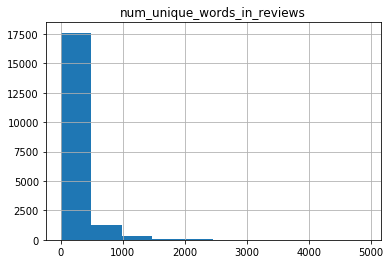

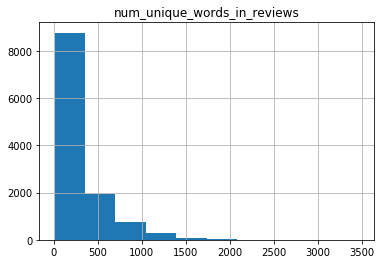

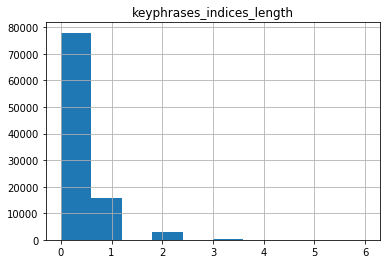

In [15]:
# for use_lemmatizer in [True]:
#     for num_user in [10000, 8000]:
#         for filter_user_criteria in ["num_reviews", "num_words_in_reviews", "num_unique_words_in_reviews"]:
#             for num_item in [8000, 6000, 4000]:
#                 for filter_item_criteria in ["num_reviews", "num_words_in_reviews", "num_unique_words_in_reviews"]:
#                     for filter_by_type in [True, False]:
#                         for freq_filter in [600, 1000]:
#                             df_cur = process_dataset(df, use_lemmatizer=use_lemmatizer,  
#                                                      remove_user=True, num_user=num_user, 
#                                                      filter_user_criteria=filter_user_criteria, 
#                                                      remove_item=True, num_item=num_item, 
#                                                      filter_item_criteria=filter_item_criteria, 
#                                                      filter_by_type=filter_by_type, 
#                                                      freq_filter=freq_filter, num_keyPhrases=100)

df_cur = process_dataset(df, use_lemmatizer=False, 
                remove_user=True, num_user=10000, filter_user_criteria="num_unique_words_in_reviews", 
                remove_item=True, num_item=8000, filter_item_criteria="num_unique_words_in_reviews", 
                filter_by_type=False, freq_filter=300, num_keyPhrases=50)

In [15]:
df_cur.head()

,reviewerID,asin,helpful,reviewText,overall,summary,review_word_tokenized,keyVector,keyphrases_indices_length,UserIndex,ItemIndex,Binary
2,A21KH420DK0ICA,0439893577,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,"[both, side, magnetic, a, real, plus, re, ente...",[],0,2690,0,1
4,ACCH8EOML6FN5,0439893577,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,"[i, stainless, steel, refrigerator, therefore,...",[],0,8249,0,1
5,A1EDPGHC9EYBUN,0439893577,"[0, 0]",this is a nice magnetic board for the kids to ...,3.0,grandma,"[nice, magnetic, board, kid, carry, around, pl...",[],0,982,0,0
8,AFGGC7SIV964O,0439893577,"[0, 0]",This is good product to have with unlimited po...,4.0,A must have for any homeschooling classroom !,"[this, good, product, unlimited, possibility, ...",[5],1,8474,0,1
9,A2XU46XXNV19C8,0439893577,"[59, 59]",I keep this board on top of the hallway table ...,3.0,Nifty little thing,"[i, keep, board, top, hallway, table, i, quick...",[],0,5087,0,0


In [132]:
# trigrams = nltk.collocations.TrigramAssocMeasures()
# tokens = itertools.chain.from_iterable(token_list)
# trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
# trigram_freq = trigramFinder.ngram_fd.items()

# trigramFreqTable = pd.DataFrame(list(trigram_freq), 
#                                 columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# trigramFreqTable = trigramFreqTable[trigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [133]:
# trigramFreqTable.head(50)

,ngram,freq
293225,"(old, like, play)",44
414257,"(old, like, toy)",18
1639,"(old, like, i)",16
277206,"(old, like, lot)",16
446468,"(overall, though, i)",15
644639,"(much, like, i)",13
239162,"(wish, around, i)",13
2423732,"(update, if, re)",12
832111,"(durable, in, fact)",11
3736119,"(average, per, piece)",11


In [ ]:
# df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

In [ ]:
# df['keyVector'] = df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

In [ ]:
# df['keyIndices'] = df['keyVector'].apply(lambda vector: [i for i, x in enumerate(vector) if x == 1.])

In [ ]:
# df['keyIndices'].str.len().sum()

In [143]:
df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
df['Binary'] = (df[rating] > 3)*1

In [144]:
df_user_name = df[['UserIndex',userID]]
df_item_name = df[['ItemIndex',itemID]]

In [145]:
# df = df.drop([itemID, userID, reviewText], axis=1)

## DataFrames

In [146]:
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,review_word_tokenized,UserIndex,ItemIndex,Binary
0,A1VXOAVRGKGEAK,0439893577,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,"[i, like, item, pricing, my, granddaughter, wa...",4516,0,1
1,A8R62G708TSCM,0439893577,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,"[love, magnet, easel, great, moving, different...",15552,0,1
2,A21KH420DK0ICA,0439893577,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,"[both, side, magnetic, a, real, plus, re, ente...",5307,0,1
3,AR29QK6HPFYZ4,0439893577,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,"[bought, one, year, ago, daughter, love, still...",18104,0,1
4,ACCH8EOML6FN5,0439893577,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,"[i, stainless, steel, refrigerator, therefore,...",16040,0,1


In [147]:
df_word_index.head()

,word,index
0,i,1
1,s,2
2,the,3
3,nt,4
4,game,5


In [148]:
df_keyphrases.head()

,Phrases
0,puerto rico
1,shrinky dink
2,harry potter
3,wit wager
4,strawberry shortcake


In [149]:
df_user_name.head()

,UserIndex,reviewerID
0,4516,A1VXOAVRGKGEAK
1,15552,A8R62G708TSCM
2,5307,A21KH420DK0ICA
3,18104,AR29QK6HPFYZ4
4,16040,ACCH8EOML6FN5


In [150]:
df_item_name.head()

,ItemIndex,asin
0,0,0439893577
1,0,0439893577
2,0,0439893577
3,0,0439893577
4,0,0439893577


## Statistic

In [151]:
print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))

Number of User: 19412
Number of Item: 11924
Number of Positive Review: 140235


In [ ]:
df['vector'] = tokenizer.texts_to_sequences(text)

In [ ]:
review_lengths = df.vector.apply(lambda x: len(x)).tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(review_lengths, normed=True, bins=30)
plt.ylabel('Probability');

## Save

In [ ]:
df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')